# Serial Dependence Analysis - Bocheva & Rahnev (2025)
## Analysis Version 1

This notebook analyzes choice and confidence serial dependence effects in orientation discrimination task with hand/action manipulations.

**Main analyses:**
1. Choice serial dependence: Response(t) = b0 + b1·Response(t-1) + ε
2. Confidence serial dependence: Confidence(t) = c0 + c1·Confidence(t-1) + ε
3. Dominant hand effect: Previous left vs. right hand

**Date:** 2025-11-15

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import linregress, ttest_rel, ttest_1samp
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

# Define paths
DATA_DIR = Path('../Raw_Data')
FIGURES_DIR = Path('figures_v1')
FIGURES_DIR.mkdir(exist_ok=True)

print("Packages loaded successfully!")

Packages loaded successfully!


## 1. Data Loading and Preprocessing

In [2]:
def load_and_clean_data(filename: str, experiment: str) -> tuple[pd.DataFrame, dict]:
    """
    Load data and apply exclusion criteria.

    Args:
        filename: Path to CSV file
        experiment: 'exp1' or 'exp2' for appropriate column names

    Returns:
        df: Cleaned DataFrame
        stats: Dictionary with exclusion statistics
    """
    print(f"\n{'='*60}")
    print(f"Loading {experiment.upper()}")
    print(f"{'='*60}")

    # Load data
    df = pd.read_csv(DATA_DIR / filename)
    raw_trials = len(df)
    raw_subjects = df['Subject'].nunique()

    # Clean subject IDs
    df['Subject'] = df['Subject'].astype(str).str.strip()

    # EXCLUSION 1: Subjects using single confidence rating >90% of trials
    conf_usage = df.groupby(['Subject', 'Confidence']).size().unstack(fill_value=0)
    conf_pct = conf_usage.div(conf_usage.sum(axis=1), axis=0)
    excluded_subjects = conf_pct[conf_pct.max(axis=1) > 0.9].index.tolist()

    print(f"\nSubject exclusion:")
    print(f"  - Total subjects: {raw_subjects}")
    print(f"  - Excluded (>90% single rating): {len(excluded_subjects)}")

    df = df[~df['Subject'].isin(excluded_subjects)]

    # EXCLUSION 2: Trials with RT >= 3 seconds
    trials_after_subj = len(df)
    df = df[(df['RT_Decision'] < 3) & (df['RT_Confidence'] < 3)]
    excluded_trials = trials_after_subj - len(df)

    print(f"\nTrial exclusion:")
    print(f"  - Trials after subject exclusion: {trials_after_subj}")
    print(f"  - Excluded (RT >= 3s): {excluded_trials}")
    print(f"  - Valid trials: {len(df)}")
    print(f"  - Valid subjects: {df['Subject'].nunique()}")

    stats = {
        'raw_trials': raw_trials,
        'raw_subjects': raw_subjects,
        'excluded_subjects': len(excluded_subjects),
        'excluded_trials': excluded_trials,
        'valid_trials': len(df),
        'valid_subjects': df['Subject'].nunique()
    }

    return df, stats

## 2. Serial Dependence Analysis Functions

In [3]:
def compute_serial_dependence_slopes(
    df: pd.DataFrame,
    variable: str,
    condition_column: str
) -> tuple[list, list]:
    """
    Compute serial dependence slopes for repeat vs. switch trials.

    Args:
        df: DataFrame with Subject, variable, and condition columns
        variable: Column name ('Response' or 'Confidence')
        condition_column: Column defining hand/action ('Side' or 'Hand')

    Returns:
        repeat_slopes: List of β coefficients for repeat trials
        switch_slopes: List of β coefficients for switch trials
    """
    repeat_slopes = []
    switch_slopes = []

    for subject in df['Subject'].unique():
        subj_data = df[df['Subject'] == subject].copy()

        # Create lagged variables within subject
        subj_data['lagged_var'] = subj_data[variable].shift(1)
        subj_data['lagged_cond'] = subj_data[condition_column].shift(1)

        # Drop NaN values from lagging
        subj_data = subj_data.dropna(subset=['lagged_var', 'lagged_cond'])

        # Separate repeat vs. switch trials
        repeat_mask = subj_data[condition_column] == subj_data['lagged_cond']
        switch_mask = subj_data[condition_column] != subj_data['lagged_cond']

        repeat_trials = subj_data[repeat_mask]
        switch_trials = subj_data[switch_mask]

        # Fit linear regression for repeat trials
        if len(repeat_trials) > 10:  # Require minimum data
            slope, _, _, _, _ = linregress(
                repeat_trials['lagged_var'],
                repeat_trials[variable]
            )
            repeat_slopes.append(slope)

        # Fit linear regression for switch trials
        if len(switch_trials) > 10:
            slope, _, _, _, _ = linregress(
                switch_trials['lagged_var'],
                switch_trials[variable]
            )
            switch_slopes.append(slope)

    return repeat_slopes, switch_slopes


def compute_dominant_hand_slopes(
    df: pd.DataFrame,
    variable: str,
    condition_column: str
) -> tuple[list, list]:
    """
    Compute serial dependence slopes by previous hand used.

    Args:
        df: DataFrame with data
        variable: 'Confidence' or 'Response'
        condition_column: 'Side' or 'Hand'

    Returns:
        prev_left_slopes: Slopes for previous left-hand trials
        prev_right_slopes: Slopes for previous right-hand trials
    """
    prev_left_slopes = []
    prev_right_slopes = []

    for subject in df['Subject'].unique():
        subj_data = df[df['Subject'] == subject].copy()

        # Create lagged variables
        subj_data['lagged_var'] = subj_data[variable].shift(1)
        subj_data['lagged_cond'] = subj_data[condition_column].shift(1)
        subj_data = subj_data.dropna(subset=['lagged_var', 'lagged_cond'])

        # Separate by previous hand (1=left, 2=right)
        prev_left = subj_data[subj_data['lagged_cond'] == 1]
        prev_right = subj_data[subj_data['lagged_cond'] == 2]

        # Fit regressions
        if len(prev_left) > 10:
            slope, _, _, _, _ = linregress(prev_left['lagged_var'], prev_left[variable])
            prev_left_slopes.append(slope)

        if len(prev_right) > 10:
            slope, _, _, _, _ = linregress(prev_right['lagged_var'], prev_right[variable])
            prev_right_slopes.append(slope)

    return prev_left_slopes, prev_right_slopes

## 3. Statistical Analysis Functions

In [4]:
def compute_statistics(
    slopes1: list,
    slopes2: list,
    labels: tuple[str, str]
) -> dict:
    """
    Compute t-tests and Cohen's d for two sets of slopes.

    Args:
        slopes1: First set of slopes
        slopes2: Second set of slopes
        labels: Tuple of (label1, label2) for output

    Returns:
        Dictionary with statistical results
    """
    slopes1 = np.array(slopes1)
    slopes2 = np.array(slopes2)

    # One-sample t-tests (slopes vs. 0)
    t_stat1, p_val1 = ttest_1samp(slopes1, 0)
    cohen_d1 = np.mean(slopes1) / np.std(slopes1, ddof=1)

    t_stat2, p_val2 = ttest_1samp(slopes2, 0)
    cohen_d2 = np.mean(slopes2) / np.std(slopes2, ddof=1)

    # Paired t-test (slopes1 vs. slopes2)
    t_stat_paired, p_val_paired = ttest_rel(slopes1, slopes2)

    # Cohen's d for paired comparison
    diff = slopes1 - slopes2
    cohen_d_paired = np.mean(diff) / np.std(diff, ddof=1)

    results = {
        'mean1': np.mean(slopes1),
        'sd1': np.std(slopes1, ddof=1),
        'mean2': np.mean(slopes2),
        'sd2': np.std(slopes2, ddof=1),
        't_stat1': t_stat1,
        'p_val1': p_val1,
        'cohen_d1': cohen_d1,
        't_stat2': t_stat2,
        'p_val2': p_val2,
        'cohen_d2': cohen_d2,
        't_stat_paired': t_stat_paired,
        'p_val_paired': p_val_paired,
        'cohen_d_paired': cohen_d_paired,
        'df': len(slopes1) - 1,
        'labels': labels
    }

    return results


def report_statistics(results: dict, title: str):
    """Print statistical results in APA format."""
    print(f"\n{title}")
    print("-" * 60)

    label1, label2 = results['labels']

    print(f"\n{label1}:")
    print(f"  M = {results['mean1']:.2f}, SD = {results['sd1']:.2f}")
    print(f"  One-sample t-test vs. 0: t({results['df']}) = {results['t_stat1']:.2f}, "
          f"p {format_p_value(results['p_val1'])}, d = {results['cohen_d1']:.2f}")

    print(f"\n{label2}:")
    print(f"  M = {results['mean2']:.2f}, SD = {results['sd2']:.2f}")
    print(f"  One-sample t-test vs. 0: t({results['df']}) = {results['t_stat2']:.2f}, "
          f"p {format_p_value(results['p_val2'])}, d = {results['cohen_d2']:.2f}")

    print(f"\nPaired comparison ({label1} vs. {label2}):")
    print(f"  t({results['df']}) = {results['t_stat_paired']:.2f}, "
          f"p {format_p_value(results['p_val_paired'])}, d = {results['cohen_d_paired']:.2f}")


def format_p_value(p: float) -> str:
    """Format p-value in APA style."""
    if p < 0.001:
        return "< .001"
    else:
        return f"= {p:.3f}".replace('0.', '.')

## 4. Visualization Functions

In [5]:
def plot_serial_dependence(
    slopes1: list,
    slopes2: list,
    labels: tuple[str, str],
    p_value: float,
    title: str,
    filename: str
):
    """
    Create bar plot with individual data points for serial dependence.

    Args:
        slopes1: First set of slopes (e.g., repeat)
        slopes2: Second set of slopes (e.g., switch)
        labels: Tuple of (label1, label2)
        p_value: p-value for comparison
        title: Figure title
        filename: Output filename (without extension)
    """
    slopes1 = np.array(slopes1)
    slopes2 = np.array(slopes2)

    # Calculate means and SEMs
    mean1 = np.mean(slopes1)
    sem1 = np.std(slopes1, ddof=1) / np.sqrt(len(slopes1))
    mean2 = np.mean(slopes2)
    sem2 = np.std(slopes2, ddof=1) / np.sqrt(len(slopes2))

    # Create figure
    fig, ax = plt.subplots(figsize=(9, 8))
    mpl.rcParams['font.family'] = 'DejaVu Sans'

    # Plot bars
    bar_positions = [0, 1]
    colors = ['#4A90E2', '#E24A4A']  # Blue, Red

    bars = ax.bar(
        bar_positions,
        [mean1, mean2],
        yerr=[sem1, sem2],
        color=colors,
        alpha=0.7,
        width=0.6,
        capsize=10,
        error_kw={'linewidth': 2}
    )

    # Add individual data points with jitter
    np.random.seed(42)  # Consistent jitter
    jitter1 = np.random.normal(0, 0.03, len(slopes1))
    jitter2 = np.random.normal(0, 0.03, len(slopes2))

    ax.scatter(
        bar_positions[0] + jitter1,
        slopes1,
        color=colors[0],
        edgecolor='black',
        s=60,
        alpha=0.6,
        zorder=3,
        linewidth=0.5
    )

    ax.scatter(
        bar_positions[1] + jitter2,
        slopes2,
        color=colors[1],
        edgecolor='black',
        s=60,
        alpha=0.6,
        zorder=3,
        linewidth=0.5
    )

    # Connect paired points
    for i in range(len(slopes1)):
        ax.plot(
            [bar_positions[0] + jitter1[i], bar_positions[1] + jitter2[i]],
            [slopes1[i], slopes2[i]],
            color='gray',
            alpha=0.3,
            linewidth=0.8,
            zorder=2
        )

    # Add significance annotation
    y_max = max(np.max(slopes1), np.max(slopes2))
    y_min = min(np.min(slopes1), np.min(slopes2))
    y_range = y_max - y_min
    y_text = y_max + 0.15 * y_range
    y_line = y_max + 0.10 * y_range

    # Significance stars
    if p_value < 0.001:
        sig_text = '***'
    elif p_value < 0.01:
        sig_text = '**'
    elif p_value < 0.05:
        sig_text = '*'
    else:
        sig_text = 'n.s.'

    ax.plot([bar_positions[0], bar_positions[1]], [y_line, y_line], 'k-', linewidth=2)
    ax.text(
        0.5,
        y_text,
        f'p {format_p_value(p_value)}',
        ha='center',
        va='bottom',
        fontsize=22
    )

    # Formatting
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(labels, fontsize=23)
    ax.set_ylabel('Serial dependence strength (β)', fontsize=24)
    ax.set_title(title, fontsize=26, pad=20)
    ax.tick_params(axis='y', labelsize=22)

    # Set y-limits with padding
    ax.set_ylim(y_min - 0.05 * y_range, y_text + 0.1 * y_range)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    plt.tight_layout()

    # Save figure
    plt.savefig(FIGURES_DIR / f'{filename}.png', dpi=300, bbox_inches='tight')
    plt.savefig(FIGURES_DIR / f'{filename}.pdf', bbox_inches='tight')

    print(f"  Saved: {filename}.png, {filename}.pdf")

    return fig

## 5. Run Analysis: Experiment 1

In [6]:
# Load and clean Experiment 1 data
df1, stats1 = load_and_clean_data('exp1.csv', 'Experiment 1')


Loading EXPERIMENT 1

Subject exclusion:
  - Total subjects: 45
  - Excluded (>90% single rating): 3

Trial exclusion:
  - Trials after subject exclusion: 42000
  - Excluded (RT >= 3s): 940
  - Valid trials: 41060
  - Valid subjects: 42



CONFIDENCE SERIAL DEPENDENCE - EXPERIMENT 1

Computed slopes for 42 subjects

Confidence Serial Dependence Statistics
------------------------------------------------------------

Repeat:
  M = 0.33, SD = 0.13
  One-sample t-test vs. 0: t(41) = 15.92, p < .001, d = 2.46

Switch:
  M = 0.28, SD = 0.14
  One-sample t-test vs. 0: t(41) = 13.17, p < .001, d = 2.03

Paired comparison (Repeat vs. Switch):
  t(41) = 4.91, p < .001, d = 0.76

Generating figure...
  Saved: conf_serial_dep_experiment_1.png, conf_serial_dep_experiment_1.pdf


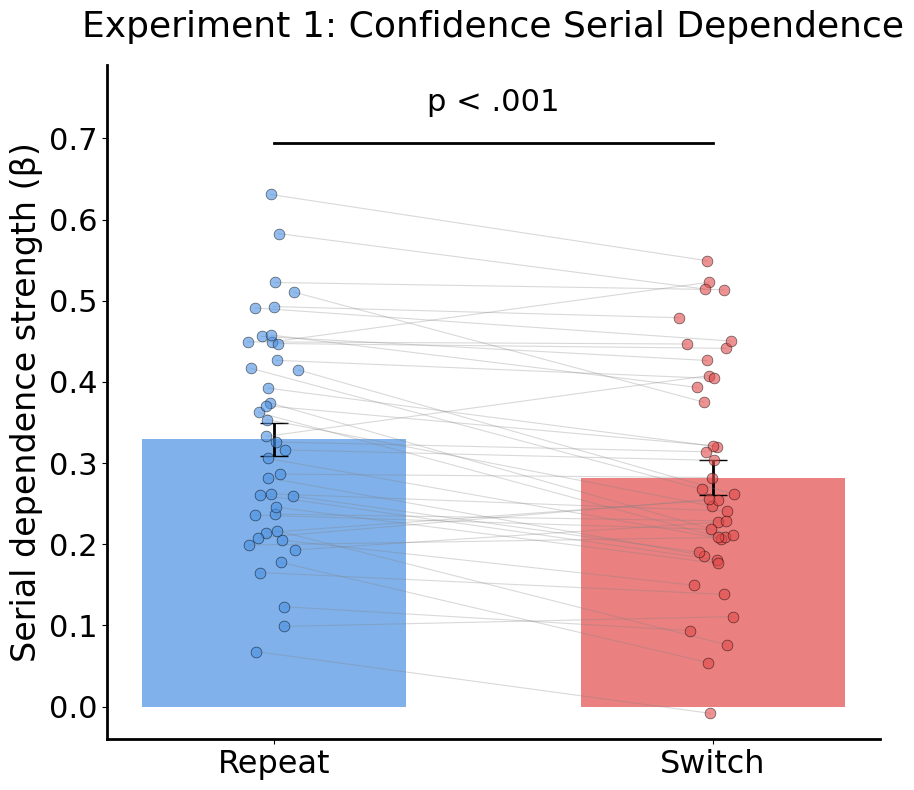

In [7]:
# Confidence Serial Dependence - Experiment 1
print("\n" + "="*60)
print("CONFIDENCE SERIAL DEPENDENCE - EXPERIMENT 1")
print("="*60)

repeat_conf1, switch_conf1 = compute_serial_dependence_slopes(
    df1, 'Confidence', 'Side'
)

print(f"\nComputed slopes for {len(repeat_conf1)} subjects")

results_conf1 = compute_statistics(
    repeat_conf1, switch_conf1,
    ('Repeat', 'Switch')
)

report_statistics(results_conf1, "Confidence Serial Dependence Statistics")

# Plot
print("\nGenerating figure...")
fig1 = plot_serial_dependence(
    repeat_conf1,
    switch_conf1,
    ('Repeat', 'Switch'),
    results_conf1['p_val_paired'],
    'Experiment 1: Confidence Serial Dependence',
    'conf_serial_dep_experiment_1'
)
plt.show()


CHOICE SERIAL DEPENDENCE - EXPERIMENT 1

Computed slopes for 42 subjects

Choice Serial Dependence Statistics
------------------------------------------------------------

Repeat:
  M = 0.13, SD = 0.12
  One-sample t-test vs. 0: t(41) = 7.06, p < .001, d = 1.09

Switch:
  M = 0.08, SD = 0.11
  One-sample t-test vs. 0: t(41) = 5.08, p < .001, d = 0.78

Paired comparison (Repeat vs. Switch):
  t(41) = 3.53, p = .001, d = 0.55

Generating figure...
  Saved: choice_serial_dep_experiment_1.png, choice_serial_dep_experiment_1.pdf


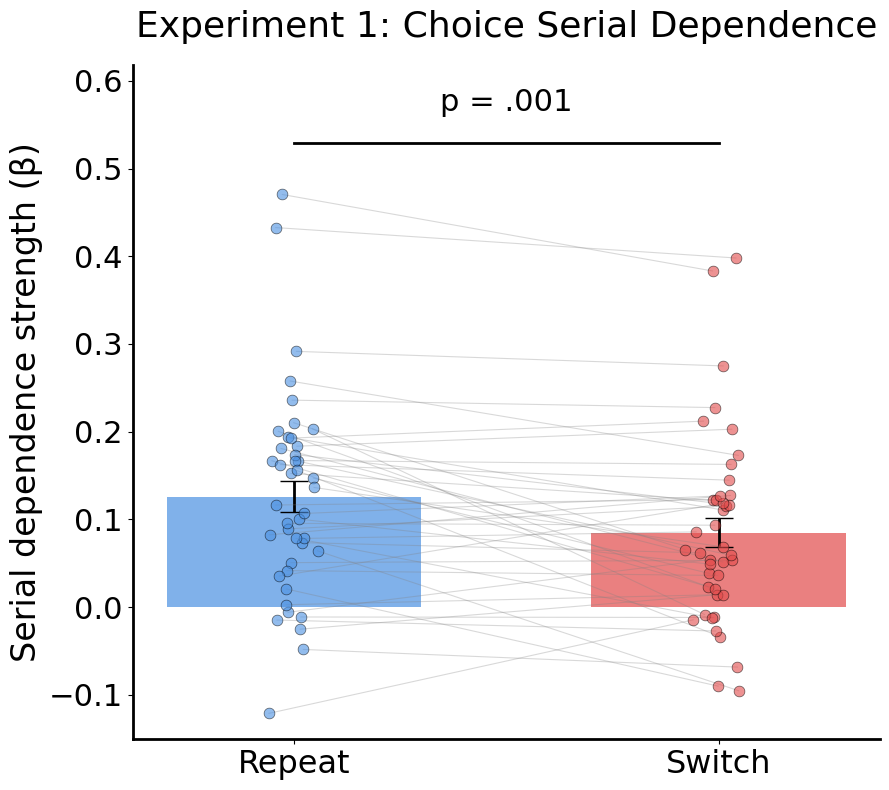

In [8]:
# Choice Serial Dependence - Experiment 1
print("\n" + "="*60)
print("CHOICE SERIAL DEPENDENCE - EXPERIMENT 1")
print("="*60)

repeat_choice1, switch_choice1 = compute_serial_dependence_slopes(
    df1, 'Response', 'Side'
)

print(f"\nComputed slopes for {len(repeat_choice1)} subjects")

results_choice1 = compute_statistics(
    repeat_choice1, switch_choice1,
    ('Repeat', 'Switch')
)

report_statistics(results_choice1, "Choice Serial Dependence Statistics")

# Plot
print("\nGenerating figure...")
fig2 = plot_serial_dependence(
    repeat_choice1,
    switch_choice1,
    ('Repeat', 'Switch'),
    results_choice1['p_val_paired'],
    'Experiment 1: Choice Serial Dependence',
    'choice_serial_dep_experiment_1'
)
plt.show()


DOMINANT HAND EFFECT - EXPERIMENT 1

Computed slopes for 42 subjects

Dominant Hand Effect Statistics
------------------------------------------------------------

Previous Left:
  M = 0.29, SD = 0.14
  One-sample t-test vs. 0: t(41) = 12.95, p < .001, d = 2.00

Previous Right:
  M = 0.33, SD = 0.13
  One-sample t-test vs. 0: t(41) = 16.17, p < .001, d = 2.49

Paired comparison (Previous Left vs. Previous Right):
  t(41) = -3.70, p < .001, d = -0.57

Generating figure...
  Saved: dominant_hand_experiment_1.png, dominant_hand_experiment_1.pdf


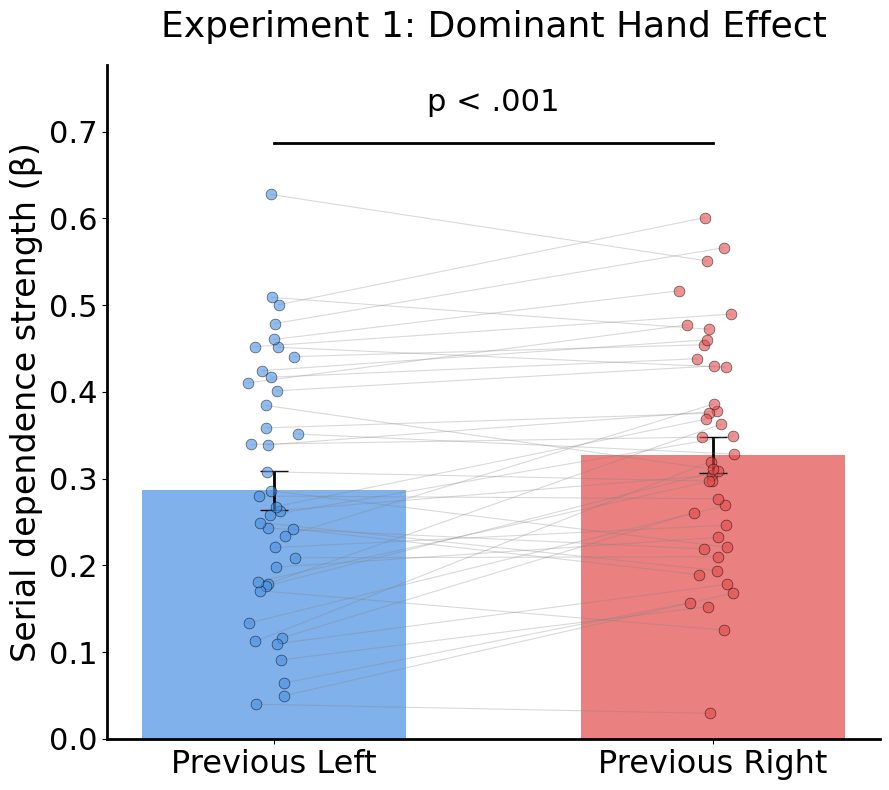

In [9]:
# Dominant Hand Effect - Experiment 1
print("\n" + "="*60)
print("DOMINANT HAND EFFECT - EXPERIMENT 1")
print("="*60)

prev_left1, prev_right1 = compute_dominant_hand_slopes(
    df1, 'Confidence', 'Side'
)

print(f"\nComputed slopes for {len(prev_left1)} subjects")

results_hand1 = compute_statistics(
    prev_left1, prev_right1,
    ('Previous Left', 'Previous Right')
)

report_statistics(results_hand1, "Dominant Hand Effect Statistics")

# Plot
print("\nGenerating figure...")
fig3 = plot_serial_dependence(
    prev_left1,
    prev_right1,
    ('Previous Left', 'Previous Right'),
    results_hand1['p_val_paired'],
    'Experiment 1: Dominant Hand Effect',
    'dominant_hand_experiment_1'
)
plt.show()

## 6. Run Analysis: Experiment 2

In [10]:
# Load and clean Experiment 2 data
df2, stats2 = load_and_clean_data('exp2.csv', 'Experiment 2')


Loading EXPERIMENT 2

Subject exclusion:
  - Total subjects: 51
  - Excluded (>90% single rating): 1

Trial exclusion:
  - Trials after subject exclusion: 50000
  - Excluded (RT >= 3s): 2324
  - Valid trials: 47676
  - Valid subjects: 50



CONFIDENCE SERIAL DEPENDENCE - EXPERIMENT 2

Computed slopes for 50 subjects

Confidence Serial Dependence Statistics
------------------------------------------------------------

Repeat:
  M = 0.35, SD = 0.13
  One-sample t-test vs. 0: t(49) = 18.61, p < .001, d = 2.63

Switch:
  M = 0.26, SD = 0.18
  One-sample t-test vs. 0: t(49) = 10.24, p < .001, d = 1.45

Paired comparison (Repeat vs. Switch):
  t(49) = 3.93, p < .001, d = 0.56

Generating figure...
  Saved: conf_serial_dep_experiment_2.png, conf_serial_dep_experiment_2.pdf


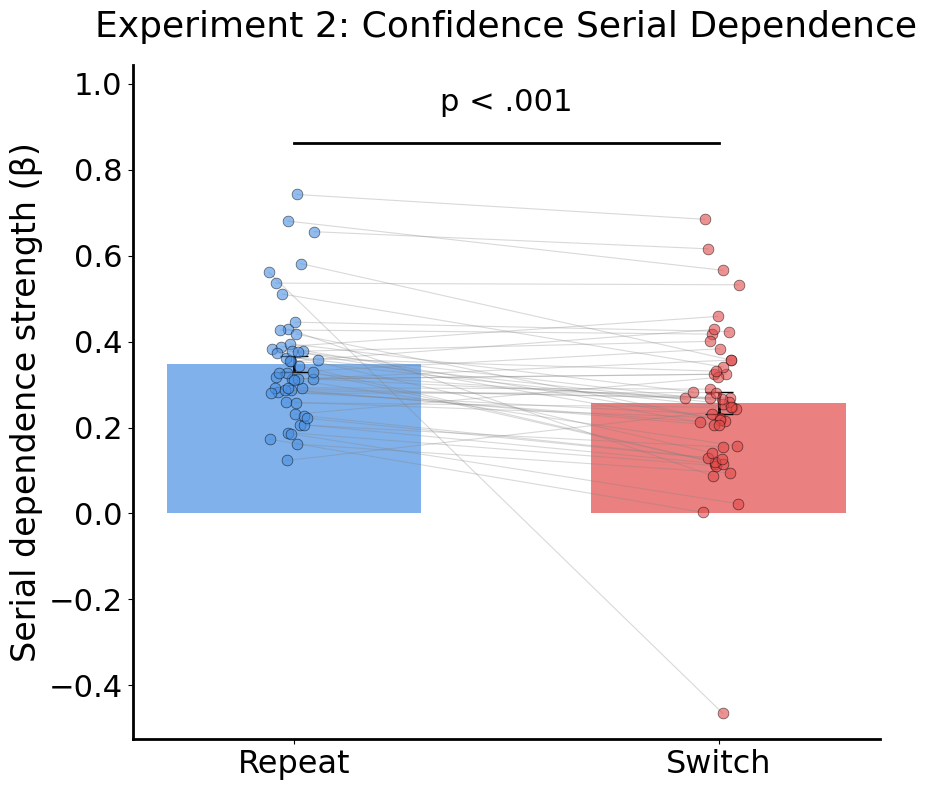

In [11]:
# Confidence Serial Dependence - Experiment 2
print("\n" + "="*60)
print("CONFIDENCE SERIAL DEPENDENCE - EXPERIMENT 2")
print("="*60)

repeat_conf2, switch_conf2 = compute_serial_dependence_slopes(
    df2, 'Confidence', 'Hand'
)

print(f"\nComputed slopes for {len(repeat_conf2)} subjects")

results_conf2 = compute_statistics(
    repeat_conf2, switch_conf2,
    ('Repeat', 'Switch')
)

report_statistics(results_conf2, "Confidence Serial Dependence Statistics")

# Plot
print("\nGenerating figure...")
fig4 = plot_serial_dependence(
    repeat_conf2,
    switch_conf2,
    ('Repeat', 'Switch'),
    results_conf2['p_val_paired'],
    'Experiment 2: Confidence Serial Dependence',
    'conf_serial_dep_experiment_2'
)
plt.show()


CHOICE SERIAL DEPENDENCE - EXPERIMENT 2

Computed slopes for 50 subjects

Choice Serial Dependence Statistics
------------------------------------------------------------

Repeat:
  M = 0.11, SD = 0.10
  One-sample t-test vs. 0: t(49) = 7.86, p < .001, d = 1.11

Switch:
  M = 0.07, SD = 0.09
  One-sample t-test vs. 0: t(49) = 4.95, p < .001, d = 0.70

Paired comparison (Repeat vs. Switch):
  t(49) = 4.88, p < .001, d = 0.69

Generating figure...
  Saved: choice_serial_dep_experiment_2.png, choice_serial_dep_experiment_2.pdf


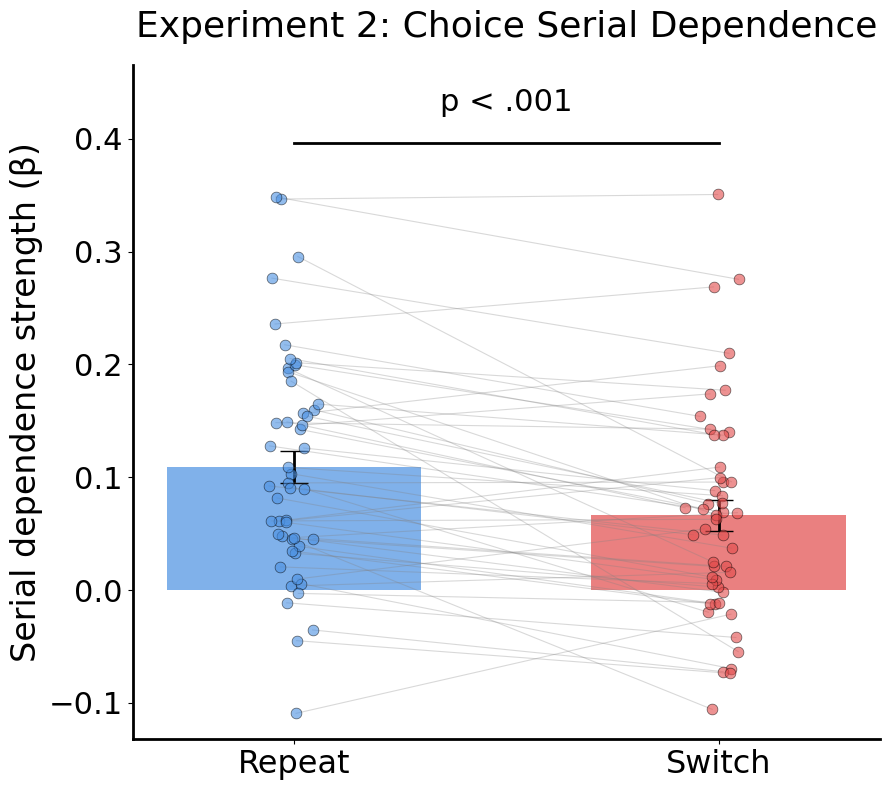

In [12]:
# Choice Serial Dependence - Experiment 2
print("\n" + "="*60)
print("CHOICE SERIAL DEPENDENCE - EXPERIMENT 2")
print("="*60)

repeat_choice2, switch_choice2 = compute_serial_dependence_slopes(
    df2, 'Response', 'Hand'
)

print(f"\nComputed slopes for {len(repeat_choice2)} subjects")

results_choice2 = compute_statistics(
    repeat_choice2, switch_choice2,
    ('Repeat', 'Switch')
)

report_statistics(results_choice2, "Choice Serial Dependence Statistics")

# Plot
print("\nGenerating figure...")
fig5 = plot_serial_dependence(
    repeat_choice2,
    switch_choice2,
    ('Repeat', 'Switch'),
    results_choice2['p_val_paired'],
    'Experiment 2: Choice Serial Dependence',
    'choice_serial_dep_experiment_2'
)
plt.show()


DOMINANT HAND EFFECT - EXPERIMENT 2

Computed slopes for 50 subjects

Dominant Hand Effect Statistics
------------------------------------------------------------

Previous Left:
  M = 0.29, SD = 0.13
  One-sample t-test vs. 0: t(49) = 16.00, p < .001, d = 2.26

Previous Right:
  M = 0.33, SD = 0.14
  One-sample t-test vs. 0: t(49) = 16.55, p < .001, d = 2.34

Paired comparison (Previous Left vs. Previous Right):
  t(49) = -3.91, p < .001, d = -0.55

Generating figure...
  Saved: dominant_hand_experiment_2.png, dominant_hand_experiment_2.pdf


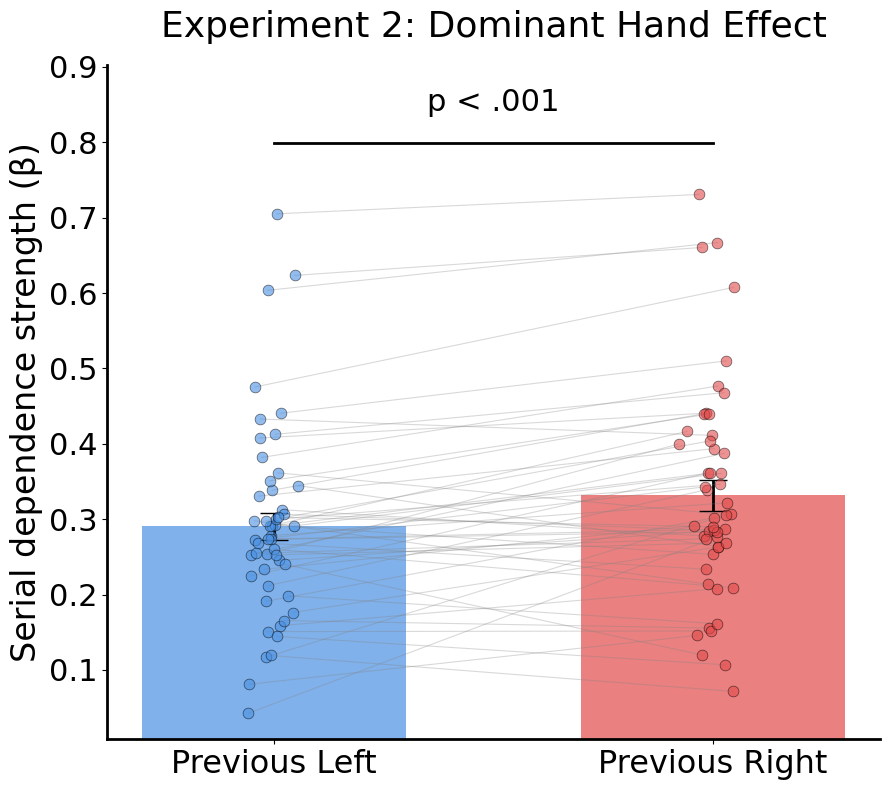

In [13]:
# Dominant Hand Effect - Experiment 2
print("\n" + "="*60)
print("DOMINANT HAND EFFECT - EXPERIMENT 2")
print("="*60)

prev_left2, prev_right2 = compute_dominant_hand_slopes(
    df2, 'Confidence', 'Hand'
)

print(f"\nComputed slopes for {len(prev_left2)} subjects")

results_hand2 = compute_statistics(
    prev_left2, prev_right2,
    ('Previous Left', 'Previous Right')
)

report_statistics(results_hand2, "Dominant Hand Effect Statistics")

# Plot
print("\nGenerating figure...")
fig6 = plot_serial_dependence(
    prev_left2,
    prev_right2,
    ('Previous Left', 'Previous Right'),
    results_hand2['p_val_paired'],
    'Experiment 2: Dominant Hand Effect',
    'dominant_hand_experiment_2'
)
plt.show()

## 7. Summary

All analyses complete! Generated figures saved to `figures_v1/` directory.